<a href="https://colab.research.google.com/github/SuRak35/Causal_Inference__ISI-Kolkata/blob/main/Confounding_Example_Finding_causal_effects_from_observed_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Confounding Example: Finding causal effects from observed data
Suppose we are given some data with treatment and outcome. Can we determine whether the treatment causes the outcome, or the correlation is purely due to another common cause?

In [1]:
!pip install dowhy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 11.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import dowhy
from dowhy import CausalModel
import dowhy.datasets, dowhy.plotter

# Config dict to set the logging level
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'INFO',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)

##Let’s create a mystery dataset for which we need to determine whether there is a causal effect.
Creating the dataset. It is generated from either one of two models: * Model 1: Treatment does cause outcome. * Model 2: Treatment does not cause outcome. All observed correlation is due to a common cause.



In [3]:
rvar = 1 if np.random.uniform() >0.5 else 0
data_dict = dowhy.datasets.xy_dataset(10000, effect=rvar,
                                      num_common_causes=1,
                                      sd_error=0.2)
df = data_dict['df']
print(df[["Treatment", "Outcome", "w0"]].head())

   Treatment    Outcome        w0
0   9.702215  19.939761  3.982427
1   2.228242   4.130962 -3.851937
2   8.579046  17.214985  2.649680
3   6.164065  12.195432  0.127349
4   3.369755   7.361409 -2.466822


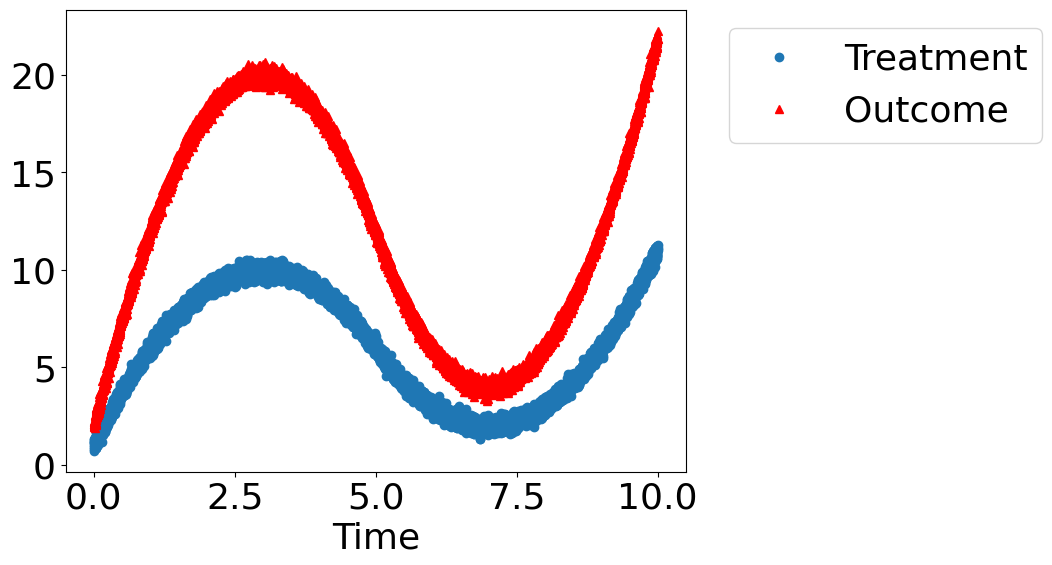

In [4]:
dowhy.plotter.plot_treatment_outcome(df[data_dict["treatment_name"]], df[data_dict["outcome_name"]],
                             df[data_dict["time_val"]])

##Using DoWhy to resolve the mystery: Does Treatment cause Outcome?

###STEP 1: Model the problem as a causal graph
Initializing the causal model.

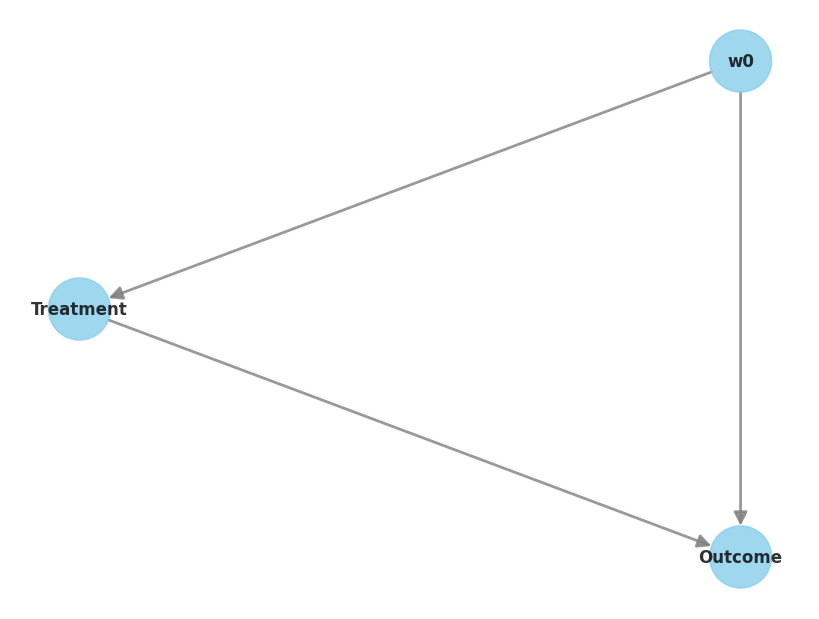

In [5]:
model= CausalModel(
        data=df,
        treatment=data_dict["treatment_name"],
        outcome=data_dict["outcome_name"],
        common_causes=data_dict["common_causes_names"],
        instruments=data_dict["instrument_names"])
model.view_model(layout="dot")

Showing the causal model stored in the local file “causal_model.png”



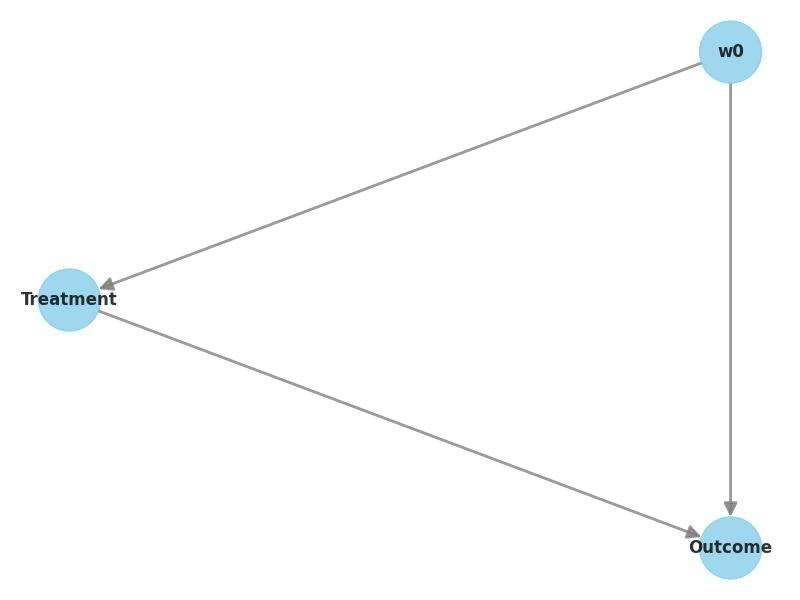

In [6]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

###STEP 2: Identify causal effect using properties of the formal causal graph
Identify the causal effect using properties of the causal graph.



In [7]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                     
────────────(E[Outcome|w0])
d[Treatment]               
Estimand assumption 1, Unconfoundedness: If U→{Treatment} and U→Outcome then P(Outcome|Treatment,w0,U) = P(Outcome|Treatment,w0)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



###STEP 3: Estimate the causal effect
Once we have identified the estimand, we can use any statistical method to estimate the causal effect.

Let’s use Linear Regression for simplicity.

/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Causal Estimate is -0.0026495046978798342


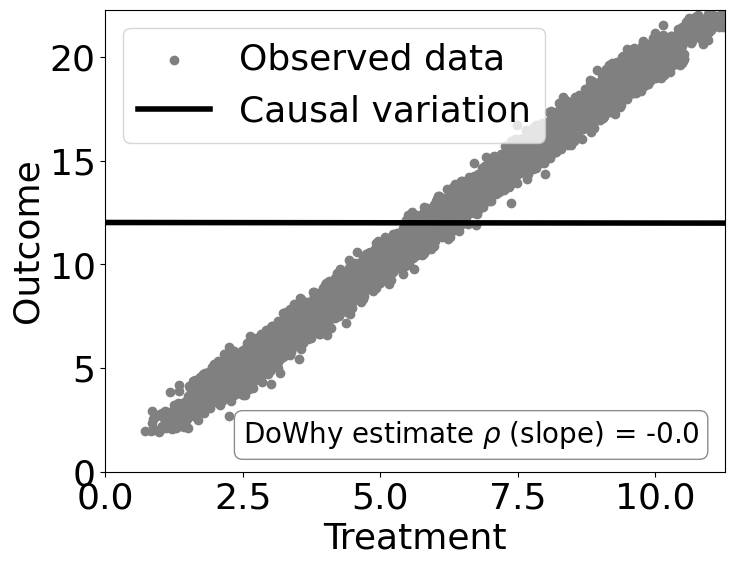

In [8]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print("Causal Estimate is " + str(estimate.value))

# Plot Slope of line between treamtent and outcome =causal effect
dowhy.plotter.plot_causal_effect(estimate, df[data_dict["treatment_name"]], df[data_dict["outcome_name"]])

####Checking if the estimate is correct

In [9]:
print("DoWhy estimate is " + str(estimate.value))
print ("Actual true causal effect was {0}".format(rvar))

DoWhy estimate is -0.0026495046978798342
Actual true causal effect was 0


###Step 4: Refuting the estimate
We can also refute the estimate to check its robustness to assumptions (aka sensitivity analysis, but on steroids).



####Adding a random common cause variable


In [10]:
res_random=model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(res_random)

/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFra

Refute: Add a random common cause
Estimated effect:-0.0026495046978798342
New effect:-0.0026448548877299415
p value:0.94



/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFra

####Replacing treatment with a random (placebo) variable


In [11]:
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFra

Refute: Use a Placebo Treatment
Estimated effect:-0.0026495046978798342
New effect:-1.8554418201812693e-05
p value:1.0



/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


####Removing a random subset of the data


In [12]:
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFra

Refute: Use a subset of data
Estimated effect:-0.0026495046978798342
New effect:-0.0027297581867083308
p value:0.94



/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFra

As we can see, our causal estimator is robust to simple refutations.